<a href="https://colab.research.google.com/github/SubhraSMukherjee/Factor_Analysis/blob/main/LGBM_Factor_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyzing relative impact of Factors causing Customer Churn

>**Problem Statement:** Understanding customer churn is crucial for businesses to identify patterns, factors, and indicators that contribute to customer attrition. By modelling churn behavior on its associated features, we isolate the key **reasons** of churn and their relative importance. These reasons can be further analysed and improved on to reduce overall churn

[[Data Source]](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset/)
*Customer Churn Dataset*

___

>### Import Dependencies

In [ ]:
from google.colab import drive
import re
import numpy as np
import pandas as pd
import random
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import warnings

>### Mount Drive to import CSV (~30MB) and Load Data

In [ ]:
drive.mount('/content/drive', force_remount=True)
path_training = '/content/drive/My Drive/Colab_Notebooks/customer_churn_dataset_training_master.csv'
customer_churn_dataset_all = pd.read_csv(path_training).reset_index(drop=True)

Mounted at /content/drive


In [ ]:
customer_churn_dataset_all = customer_churn_dataset_all.drop(customer_churn_dataset_all[customer_churn_dataset_all.isnull().any(axis=1)].index)
customer_churn_dataset_all[['CustomerID', 'Churn']] = customer_churn_dataset_all[[ 'CustomerID', 'Churn']].astype(int)
customer_churn_dataset_all

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1
1,3,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1
2,4,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1
3,5,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1
4,6,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
440828,449995,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0
440829,449996,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0
440830,449997,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0
440831,449998,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0


In [ ]:
original_features = customer_churn_dataset_all.columns

___

>### Bin Continious Data

>**Reason:** The Underlying Decision Trees are just trying to isolate axis parallel subspaces of the entire Parameter Space with the most homogenity (i.e., Lower log loss). Binning helps the base learners achieve that more than the histogram based algorithms that they employ. Always a good idea to bin continious values when using GBDTs

In [ ]:
no_of_bins = 5
for feature in customer_churn_dataset_all.columns:
  if customer_churn_dataset_all[feature].dtype == 'float':
    feature_bin = f"{feature} bin"
    customer_churn_dataset_all[feature_bin] = pd.cut(np.array(customer_churn_dataset_all[feature].values), no_of_bins)

In [ ]:
random.sample(list(customer_churn_dataset_all), 5)

['Contract Length',
 'Gender',
 'Payment Delay',
 'Last Interaction bin',
 'Tenure bin']

In [ ]:
features = [feature for feature in customer_churn_dataset_all.columns if feature not in [ 'CustomerID', 'Churn']]
churn_feature_data = customer_churn_dataset_all[features]
churn_prediction_data = customer_churn_dataset_all.Churn

>### Encoding the categorical columns and also the binned values previously created

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
categorical_columns = churn_feature_data.select_dtypes(include=['object', 'category']).columns.tolist()
one_hot_encoded = encoder.fit_transform(churn_feature_data[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns),  index=churn_feature_data.index)
churn_feature_data_encoded = pd.concat([churn_feature_data, one_hot_df], axis=1)
churn_feature_data_encoded = churn_feature_data_encoded.drop(categorical_columns, axis=1)

In [ ]:
#churn_feature_data_encoded = churn_feature_data_encoded.rename(columns = lambda x:re.sub('[^A-Za-z0-9_.,\s\\(\\]]+', '_', x).lower())
churn_feature_data_encoded = churn_feature_data_encoded.rename(columns = lambda x:re.sub(r'[^A-Za-z0-9_]+', '_', x).lower())
random.sample(list(churn_feature_data_encoded),5)

['last_interaction_bin__12_6_18_4_',
 'support_calls_bin__2_0_4_0_',
 'tenure_bin__48_2_60_0_',
 'usage_frequency',
 'total_spend_bin__280_0_460_0_']

>### Randomly Split the Data for Testing

In [ ]:
features_train ,features_test ,prediction_train ,prediction_test = train_test_split(churn_feature_data_encoded , churn_prediction_data ,test_size=0.2 ,shuffle=True ,random_state=55)

___

>### Gradient Boosted Machines can overfit data easily so we use a 5 fold cross validation with a Parameter Search to select the Model enabling emperical risk minimization

>**Parameter Search:** Parameter Search with Cross Validation is an extremely expensive operation. In my case, Fitting 5 folds for each of the 4 parameter grid combination means 20 fits. The total number of fits increases exponentially with larger Parameter Grids

In [ ]:
param_grid = {
#"num_leaves": [5, 7],
"max_depth": [ 3, 5],
"learning_rate": [0.01],
"n_estimators": [20, 50],
"subsample": [0.8],
"colsample_bytree": [0.8],
"subsample_for_bin": [300000]
}

In [ ]:
warnings.filterwarnings("ignore")
lgbm = lgb.LGBMClassifier(objective="binary", metric="binary_logloss", random_state=57, verbose=-1)
grid = GridSearchCV(lgbm, param_grid, cv=5, verbose=3, n_jobs=-1, scoring="accuracy")
grid.fit(features_train, prediction_train.values,)
print(f"Best parameters via Grid Search: {grid.best_params_}")
print(f"Best score via Grid Search: {grid.best_score_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters via Grid Search: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8, 'subsample_for_bin': 300000}
Best score via Grid Search: 0.9780017863978563


>### Best Classifier Diagnostics

>**Conclusions:** The high accuracy scores, ROC-AUC Score and the Error Matrix all indicate data is too simplistic and without sufficient noise. Real churn data is hard to model even with many more parameters than what is available here

In [ ]:
y_pred = grid.predict(features_test)
y_test = prediction_test.values
print(f"Accuracy score: {round(accuracy_score(y_test, y_pred), 6)}\n")

Accuracy score: 0.977803



In [ ]:
y_prob = grid.predict_proba(features_test)[:, 1]
print(f"Classification report\n {classification_report(y_test, y_pred)}\n")
print(f"ROC-AUC Score\n {round(roc_auc_score(y_test, y_prob), 3)}")

Classification report
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     38191
           1       1.00      0.96      0.98     49976

    accuracy                           0.98     88167
   macro avg       0.98      0.98      0.98     88167
weighted avg       0.98      0.98      0.98     88167


ROC-AUC Score
 0.993


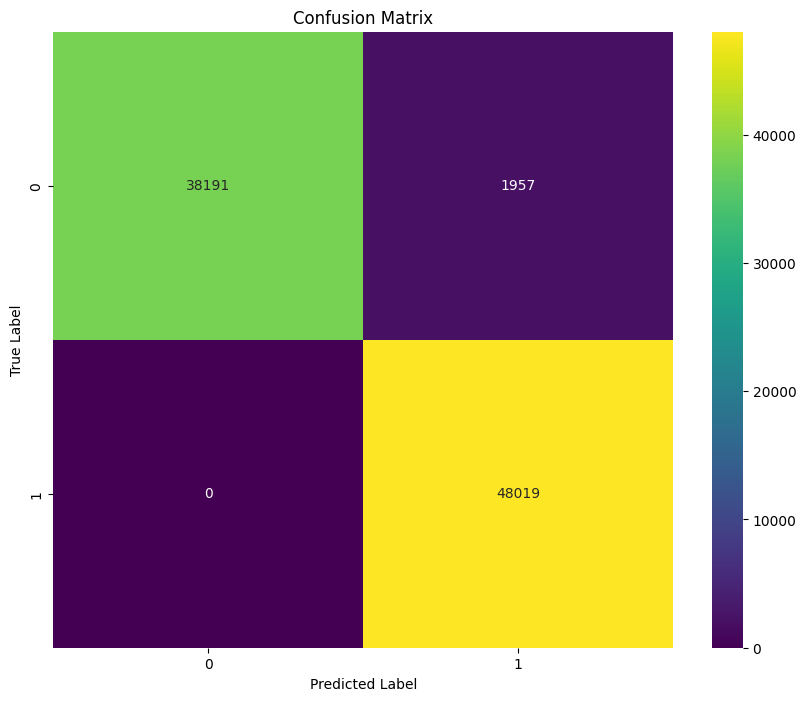

In [ ]:
error_matrix = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(10, 8))
sns.heatmap(error_matrix, annot=True, fmt=".0f", cmap="viridis")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

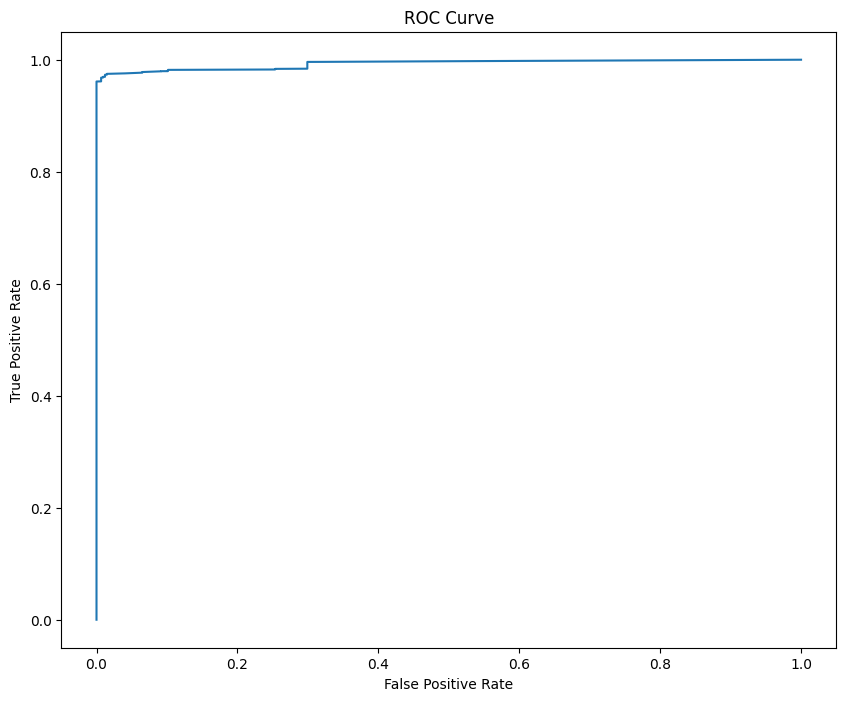

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(10, 8))
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve");

>### Identifying the most important Features for predicting Churn

>**Details:** The **information gain** achieved by splitting features is used to rank the features. Another option is the number of splits per feature but since the last few rounds of boosting may causes limited information gain (even though the number of splits keep increasing) splits may be a bit redundant

In [ ]:
params = grid.best_estimator_.get_params()
params['importance_type'] = 'gain'
params['verbose'] = -1
lgbm_best_estimator = lgb.LGBMClassifier(**params) # because early stopping is not used no slpits
lgbm_best_estimator.fit(churn_feature_data_encoded, churn_prediction_data.values)

LGBMClassifier(colsample_bytree=0.8, importance_type='gain', learning_rate=0.01,
               max_depth=5, metric='binary_logloss', n_estimators=50,
               objective='binary', random_state=57, subsample=0.8,
               subsample_for_bin=300000, verbose=-1)

In [ ]:
gain_importance_raw = pd.DataFrame({'Features': list(churn_feature_data_encoded), 'Gain': lgbm_best_estimator.feature_importances_})

In [ ]:
original_features = [feature for feature in original_features if feature not in [ 'CustomerID', 'Churn']]
gain_importance_sum = [0.0]*len(original_features)
count = [0]*len(original_features)
gain_importance_aggregated = pd.DataFrame({'Features': list(original_features), 'Total_Gain': gain_importance_sum, 'Count': count})
for feature in original_features:
  for column in list(churn_feature_data_encoded):
    if re.match(re.sub(r'[^A-Za-z0-9_]+', '_', feature).lower(), str(column)):
      gain_importance_aggregated.loc[gain_importance_aggregated['Features'] == feature, 'Total_Gain'] += float(gain_importance_raw.loc[gain_importance_raw['Features'] == column, 'Gain'].values[0])
      gain_importance_aggregated.loc[gain_importance_aggregated['Features'] == feature, 'Count'] += int(1)

In [ ]:
gain_importance_aggregated['Avg_Gain'] = (gain_importance_aggregated['Total_Gain'] / gain_importance_aggregated['Count']).map('{:.0f}'.format)
gain_importance_aggregated.sample(n=5, random_state=42)

,Features,Total_Gain,Count,Avg_Gain
8,Total Spend,3.263383e+06,6,543897
1,Gender,4.670420e+03,2,2335
5,Payment Delay,1.562200e+06,6,260367
0,Age,1.446903e+06,6,241151
7,Contract Length,1.769100e+06,3,589700


___

## Most Important Reasons (Features) for Churn

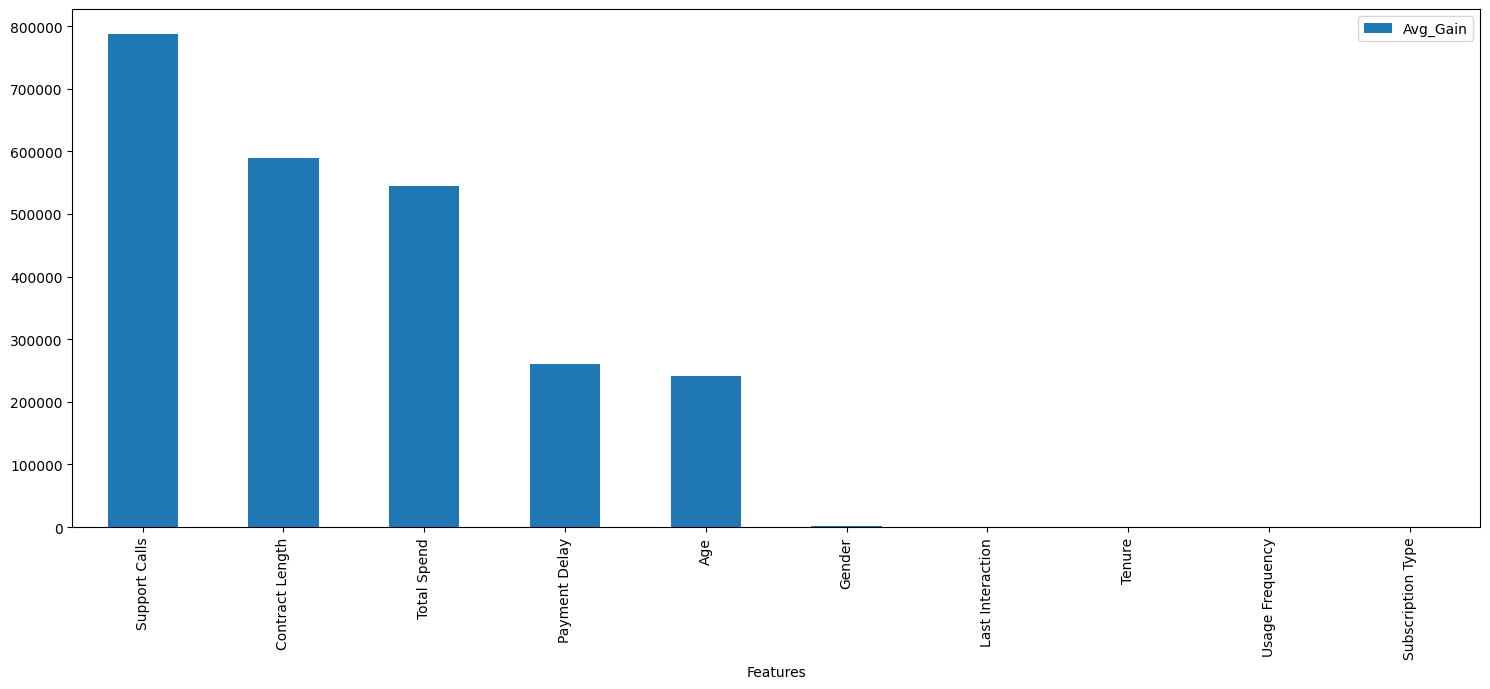

In [ ]:
ax = gain_importance_aggregated.sort_values(by = 'Avg_Gain' , ascending= False).plot(kind = 'bar', x = 'Features', y = 'Avg_Gain', figsize = (15, 7))
ax.figure.tight_layout()

>### For Instance: High number of support calls from a Customer is a predominant **Leading** indicator of Churn

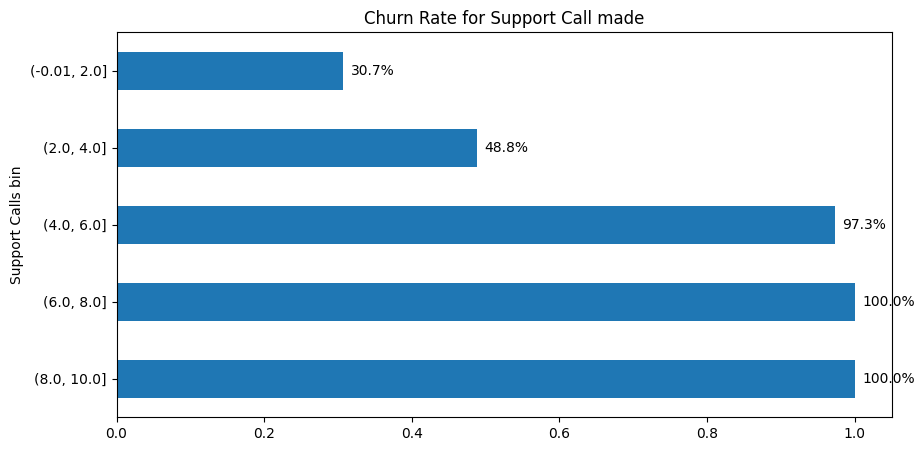

In [ ]:
customer_churn_dataset_all = pd.concat([churn_feature_data, churn_prediction_data], axis=1)
churn_per_support_bin = customer_churn_dataset_all.groupby(['Support Calls bin']).agg({'Churn': ['sum', 'count']}).apply(lambda row: row[('Churn', 'sum')] / row[('Churn', 'count')], axis=1)

ax = churn_per_support_bin.plot(kind='barh', title='Churn Rate for Support Call made', figsize = (10, 5))
ax.invert_yaxis()
for i, v in enumerate(churn_per_support_bin):
    ax.text(v + 0.01, i, f"{v:.1%}", va='center', fontsize=10)

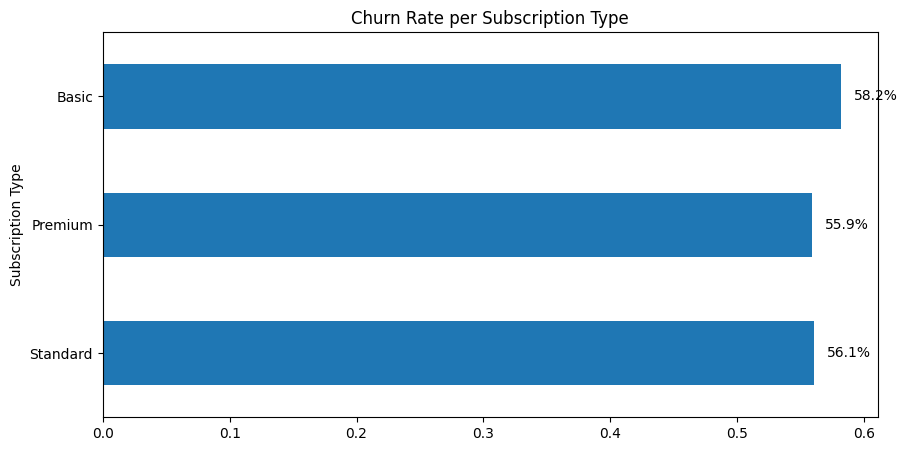

In [ ]:
churn_per_support_bin = customer_churn_dataset_all.groupby(['Subscription Type']).agg({'Churn': ['sum', 'count']}).apply(lambda row: row[('Churn', 'sum')] / row[('Churn', 'count')], axis=1)

ax = churn_per_support_bin.plot(kind='barh', title='Churn Rate per Subscription Type', figsize = (10, 5))
ax.invert_yaxis()
for i, v in enumerate(churn_per_support_bin):
    ax.text(v + 0.01, i, f"{v:.1%}", va='center', fontsize=10)